In [1]:
import pandas as pd
import numpy as np

## this data is from 
vax_df = pd.read_csv("vaccinetracking/vacc_data/data_county_current.csv",
    parse_dates=['DATE'])

## take only county-level data.
## rename to make usage of column clear
vax_df = vax_df[vax_df.GEOFLAG == 'County'].rename(columns={'COUNTY': 'FIPS'})

## these are irrelevant because we're using the date field
vax_df = vax_df.drop(['STATE', 'WEEK', 'YEAR'], axis=1)

vax_df[vax_df.FIPS == 36061]

,STATE_NAME,COUNTY_NAME,FIPS,GEOFLAG,DATE,CASE_TYPE,CASES,POPN
11016,NY,New York,36061,County,2022-02-25,Booster,5.885270e+05,1628706.0
11017,NY,New York,36061,County,2022-02-25,Booster Coverage,3.613464e+01,1628706.0
11018,NY,New York,36061,County,2022-02-25,Complete,1.365710e+06,1628706.0
11019,NY,New York,36061,County,2022-02-25,Complete Coverage,8.385246e+01,1628706.0
11020,NY,New York,36061,County,2022-02-25,Partial,1.755507e+06,1628706.0
11021,NY,New York,36061,County,2022-02-25,Partial Coverage,1.000000e+02,1628706.0


According to the [codebook](https://github.com/bansallab/vaccinetracking/tree/main/vacc_data#codebook), the columns with "Coverage" are pre-computed percentages.

"Partial/ Partial Coverage" is anybody with at least 1 shot, not people with *only* one shot.

So essentially the unvax percentage is `1 - df[df.CASE_TYPE == 'Partial Coverage' ]`

I should use raw counts when joining...

## Question 1a (MVP): Is there a correlation between vax rate and covid fatality rate?

## Question 1b (MVP): Is there a correlation between income and vaccination rate?


In [2]:
# partial_coverage = vax_df[vax_df.CASE_TYPE == 'Partial Coverage']

# unvaxed_by_fips = df.loc[df.CASE_TYPE == 'Partial Coverage', ['FIPS', 'CASES', 'POPN']]
# #partial_coverage[['FIPS', 'CASES']]

# #unvaxed_by_fips[unvaxed_by_fips.FIPS == 36061]

# unvaxed_by_fips['UNVAX_PERCENT'] = 100 - unvaxed_by_fips['CASES']

# unvaxed_by_fips = unvaxed_by_fips.drop("CASES", axis=1)    


partial  = vax_df[vax_df.CASE_TYPE == 'Partial Coverage'].pivot_table("CASES", "FIPS", "CASE_TYPE")
booster  = vax_df[vax_df.CASE_TYPE == 'Booster Coverage'].pivot_table("CASES", "FIPS", "CASE_TYPE")
complete = vax_df[vax_df.CASE_TYPE == 'Complete Coverage'].pivot_table("CASES", "FIPS", "CASE_TYPE")

popn_by_fips = vax_df.loc[vax_df.CASE_TYPE == 'Partial Coverage', ['POPN', 'FIPS']].set_index('FIPS')

In [3]:
## time to get the covid fatality rate by FIPS.

#deaths_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv"
deaths_url = 'time_series_covid19_deaths_US.csv'

deaths_df = pd.read_csv(deaths_url) # , dtype = death_dtypes)

## TODO: get the last column of the time series rather than '2/28/22' hardcoded.

cols = ['FIPS', 'Admin2', 'Province_State', '2/28/22']

deaths_cleaned = deaths_df.loc[:, cols].rename(columns={'2/28/22': 'DEATHS', 'Admin2': 'COUNTY', 
                                                        'Province_State': 'STATE' })

deaths_and_vaxed = deaths_cleaned.set_index("FIPS") \
                    .join(partial).join(booster).join(complete).join(popn_by_fips) \
                    .dropna()


deaths_and_vaxed['DEATH_RATE'] = deaths_and_vaxed['DEATHS'] / deaths_and_vaxed['POPN']

### NOTE: not dropping counties with zero deaths here (just yet)


deaths_and_vaxed

,COUNTY,STATE,DEATHS,Partial Coverage,Booster Coverage,Complete Coverage,POPN,DEATH_RATE
FIPS,,,,,,,,
1001.0,Autauga,Alabama,194,54.846158,13.685586,43.328143,55869.0,0.003472
1003.0,Baldwin,Alabama,640,63.572305,17.013537,50.058683,223234.0,0.002867
1005.0,Barbour,Alabama,93,55.010937,14.101110,44.567771,24686.0,0.003767
1007.0,Bibb,Alabama,99,42.221131,11.373582,34.285969,22394.0,0.004421
1009.0,Blount,Alabama,218,37.934493,9.998962,31.250648,57826.0,0.003770
...,...,...,...,...,...,...,...,...
56037.0,Sweetwater,Wyoming,123,57.967078,19.141298,48.919538,42343.0,0.002905
56039.0,Teton,Wyoming,16,100.000000,41.037334,91.420900,23464.0,0.000682
56041.0,Uinta,Wyoming,36,58.968654,19.489766,50.341145,20226.0,0.001780


<AxesSubplot:xlabel='Partial Coverage', ylabel='DEATH_RATE'>

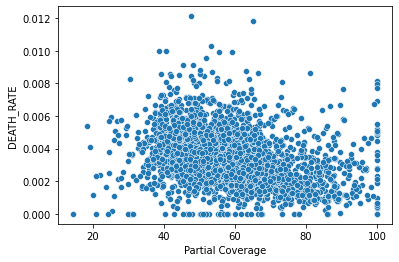

In [4]:
import seaborn as sns

sns.scatterplot(y=deaths_and_vaxed['DEATH_RATE'], x=deaths_and_vaxed['Partial Coverage'])

In [5]:
assert len(deaths_and_vaxed.loc[deaths_and_vaxed['DEATH_RATE'] > 1,:]) == 0, 'uh oh'


#sns.histplot(deaths_and_vaxed['DEATH_RATE'])

In [6]:
import numpy as np

In [7]:
#joined.UNVAX_PERCENT.corrwith(joined.DEATH_RATE)

print(deaths_and_vaxed['DEATH_RATE'].corr(deaths_and_vaxed['Partial Coverage']))
print(deaths_and_vaxed['DEATH_RATE'].corr(deaths_and_vaxed['Complete Coverage']))
print(deaths_and_vaxed['DEATH_RATE'].corr(deaths_and_vaxed['Booster Coverage']))


-0.3176906453376956
-0.34566127448879846
-0.3892495722144442


In [8]:
## there are about a million people in counties reporting 0 fatalities 
# (which must be a reporting error)

deaths_and_vaxed[deaths_and_vaxed.DEATH_RATE == 0].sort_values('POPN', ascending=False)

,COUNTY,STATE,DEATHS,Partial Coverage,Booster Coverage,Complete Coverage,POPN,DEATH_RATE
FIPS,,,,,,,,
49057.0,Weber,Utah,0,67.320234,24.873469,60.610346,260213.0,0.0
49053.0,Washington,Utah,0,57.750794,22.554574,51.431098,177556.0,0.0
49005.0,Cache,Utah,0,66.553641,22.495304,57.554428,128289.0,0.0
49003.0,Box Elder,Utah,0,57.941691,20.506370,51.352460,56046.0,0.0
49021.0,Iron,Utah,0,51.764255,17.013439,45.323584,54839.0,0.0
49047.0,Uintah,Utah,0,51.113785,14.652712,42.455365,35734.0,0.0
49039.0,Sanpete,Utah,0,46.973076,14.952002,40.473189,30939.0,0.0
49041.0,Sevier,Utah,0,50.420907,16.461610,43.422757,21620.0,0.0
49007.0,Carbon,Utah,0,55.680985,22.621317,49.411132,20463.0,0.0


In [9]:
## OK, now let's pull in county level GDP and see how the correlation goes

"""
gdp_table <- read_html("https://en.wikipedia.org/wiki/List_of_United_States_counties_by_per_capita_income") %>%
        html_element(xpath = "//table[3]") %>%
        html_table() 
        #%>%
        #mutate(CountyState = paste("County or county-equivalent", ", ", "State, federal district or territory"))

colnames(gdp_table) <- c("Rank", "County", "State",
        "PerCapita", "MedianHousehold", "MedianFamily", "Population", "NumHouseholds")
"""

#per_capita = "https://en.wikipedia.org/wiki/List_of_United_States_counties_by_per_capita_income"

per_capita = "percapita.html" # TODO: remove cache

conversions = {
                'Population': int,
                'Number ofhouseholds': int
                }

html_crud = pd.read_html(per_capita)[2]

# this will make rows with "-" in them be nan
html_crud['Rank'] = pd.to_numeric(html_crud['Rank'], errors="coerce")

html_crud = html_crud.dropna()

## deal with dollar signs, y'all
# taken from: https://stackoverflow.com/questions/32464280/converting-currency-with-to-numbers-in-python-pandas

dollar_values = ['Per capitaincome', 'Medianhouseholdincome', 'Medianfamilyincome']


for v in dollar_values:
    html_crud[v] = html_crud[v].str.replace(r"[$,]", "", regex=True).astype(int)

html_crud = html_crud.dropna()

html_crud = html_crud.rename(columns = {
                                'County or county-equivalent': 'COUNTY',
                                'Per capitaincome': 'PER_CAPITA', 
                                'Medianhouseholdincome': 'MEDIAN_HOUSEHOLD',  
                                'Medianfamilyincome': 'MEDIAN_FAMILY',
                                'State, federal district or territory': 'STATE',
                                'Population': 'POPULATION',
                                'Number ofhouseholds': 'HOUSEHOLDS',
                                'Rank': 'PER_CAPITA_RANK'}).astype({'POPULATION': int, 'HOUSEHOLDS': int})

html_crud.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3143 entries, 0 to 3267
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   PER_CAPITA_RANK   3143 non-null   float64
 1   COUNTY            3143 non-null   object 
 2   STATE             3143 non-null   object 
 3   PER_CAPITA        3143 non-null   int64  
 4   MEDIAN_HOUSEHOLD  3143 non-null   int64  
 5   MEDIAN_FAMILY     3143 non-null   int64  
 6   POPULATION        3143 non-null   int64  
 7   HOUSEHOLDS        3143 non-null   int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 221.0+ KB


In [10]:
df2 = deaths_and_vaxed.reset_index().merge(html_crud, on=['STATE', 'COUNTY'])

In [11]:
df2

,FIPS,COUNTY,STATE,DEATHS,Partial Coverage,Booster Coverage,Complete Coverage,POPN,DEATH_RATE,PER_CAPITA_RANK,PER_CAPITA,MEDIAN_HOUSEHOLD,MEDIAN_FAMILY,POPULATION,HOUSEHOLDS
0,1001.0,Autauga,Alabama,194,54.846158,13.685586,43.328143,55869.0,0.003472,1142.0,24571,53682,66349,54907,20071
1,1003.0,Baldwin,Alabama,640,63.572305,17.013537,50.058683,223234.0,0.002867,694.0,26766,50221,60864,187114,73283
2,1005.0,Barbour,Alabama,93,55.010937,14.101110,44.567771,24686.0,0.003767,2947.0,16829,32911,43462,27321,9200
3,1007.0,Bibb,Alabama,99,42.221131,11.373582,34.285969,22394.0,0.004421,2865.0,17427,36447,43004,22754,7091
4,1009.0,Blount,Alabama,218,37.934493,9.998962,31.250648,57826.0,0.003770,2150.0,20730,44145,52996,57623,21108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2947,56037.0,Sweetwater,Wyoming,123,57.967078,19.141298,48.919538,42343.0,0.002905,300.0,30517,71525,81595,44437,16682
2948,56039.0,Teton,Wyoming,16,100.000000,41.037334,91.420900,23464.0,0.000682,29.0,43444,68078,83558,21575,7583
2949,56041.0,Uinta,Wyoming,36,58.968654,19.489766,50.341145,20226.0,0.001780,942.0,25513,58515,73060,21040,7290
2950,56043.0,Washakie,Wyoming,43,46.559898,20.743113,43.446509,7805.0,0.005509,459.0,28308,47104,64608,8468,3468


In [12]:
df2.loc[df2.DEATH_RATE < .00001]

,FIPS,COUNTY,STATE,DEATHS,Partial Coverage,Booster Coverage,Complete Coverage,POPN,DEATH_RATE,PER_CAPITA_RANK,PER_CAPITA,MEDIAN_HOUSEHOLD,MEDIAN_FAMILY,POPULATION,HOUSEHOLDS
68,2060.0,Bristol Bay,Alaska,0,100.000000,37.799043,100.000000,836.0,0.0,83.0,37024,79531,96458,933,384
80,2230.0,Skagway,Alaska,0,77.599324,37.024514,68.977177,1183.0,0.0,82.0,37139,71667,77500,1080,412
170,6003.0,Alpine,California,0,46.589903,19.574845,40.389725,1129.0,0.0,938.0,25527,58636,76645,1165,394
253,8053.0,Hinsdale,Colorado,0,76.585366,33.780488,71.951220,820.0,0.0,96.0,36365,56667,76000,809,388
255,8057.0,Jackson,Colorado,0,55.172414,24.209770,50.718391,1392.0,0.0,849.0,25936,43606,60714,1371,648
282,8111.0,San Juan,Colorado,0,99.862637,50.137363,99.862637,728.0,0.0,1111.0,24711,39583,53194,659,321
520,15005.0,Kalawao,Hawaii,0,86.046512,48.837209,76.744186,86.0,0.0,23.0,45515,59375,88750,71,46
539,16033.0,Clark,Idaho,0,47.810651,14.674556,42.011834,845.0,0.0,2332.0,20032,33200,33897,751,304
1608,31083.0,Harlan,Nebraska,0,40.414201,23.520710,39.822485,3380.0,0.0,982.0,25322,45920,55400,3445,1573
1612,31103.0,Keya Paha,Nebraska,0,30.645161,16.873449,27.543424,806.0,0.0,1002.0,25251,36923,44231,698,354


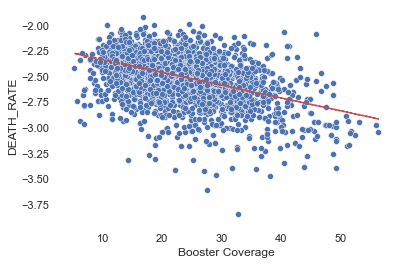

In [44]:
import matplotlib.pyplot as plt

sns.set(rc={'axes.facecolor': 'white'})

df3 = df2.loc[df2.DEATH_RATE > .0001]

df3 = df3.loc[df3['Booster Coverage'] > 5]

x = df3['Booster Coverage']
y = df3.DEATH_RATE

z = np.polyfit(x, np.log10(y), 1)
p = np.poly1d(z)

sns.scatterplot(x=x, y=np.log10(y))
#.set(yscale='log')

plt.plot(x,p(x),"r--")

# import matplotlib.pyplot as plt
# ax = plt.axes()

# ax.set_facecolor('white')

In [14]:
df2['Booster Coverage'].corr(df2['PER_CAPITA'])

0.5415810002362523

In [15]:
### now time to get community health rankings pulled in...

#ch_rankings = pd.read_excel("2021 County Health Rankings Data - v1.xlsx")

In [16]:
## TODO: get original link in here

cols = {
    'Rank':     'HEALTH_OUTCOMES_RANK',
    'Quartile': 'HEALTH_OUTCOMES_QUARTILE',
    'Rank.1':   'HEALTH_FACTORS_RANK',
    'Quartile.1':'HEALTH_FACTORS_QUARTILE'
}

ts = {
    'HEALTH_OUTCOMES_RANK': float,
    'HEALTH_OUTCOMES_QUARTILE': float,
    'HEALTH_FACTORS_RANK': float,
    'HEALTH_FACTORS_QUARTILE': float
}

xls = pd.ExcelFile("2021 County Health Rankings Data - v1.xlsx")



ch_rankings = pd.read_excel(xls, "Outcomes & Factors Rankings", header=1)

#
ch_rankings = ch_rankings[ch_rankings['Rank'] != 'NR']

ch_rankings = ch_rankings.rename(columns=cols).astype(ts).dropna()

ch_rankings['HEALTH_OUTCOMES_PERCENTILE'] = (ch_rankings['# of Ranked Counties'] - ch_rankings['HEALTH_OUTCOMES_RANK']) / ch_rankings['# of Ranked Counties']

ch_rankings['HEALTH_FACTORS_PERCENTILE'] = (ch_rankings['# of Ranked Counties'] - ch_rankings['HEALTH_FACTORS_RANK']) / ch_rankings['# of Ranked Counties']

## now convert the ranks to percentile


ch_rankings


,FIPS,State,County,# of Ranked Counties,HEALTH_OUTCOMES_RANK,HEALTH_OUTCOMES_QUARTILE,HEALTH_FACTORS_RANK,HEALTH_FACTORS_QUARTILE,HEALTH_OUTCOMES_PERCENTILE,HEALTH_FACTORS_PERCENTILE
1,1001,Alabama,Autauga,67,6.0,1.0,9.0,1.0,0.910448,0.865672
2,1003,Alabama,Baldwin,67,2.0,1.0,3.0,1.0,0.970149,0.955224
3,1005,Alabama,Barbour,67,51.0,4.0,59.0,4.0,0.238806,0.119403
4,1007,Alabama,Bibb,67,45.0,3.0,42.0,3.0,0.328358,0.373134
5,1009,Alabama,Blount,67,23.0,2.0,25.0,2.0,0.656716,0.626866
...,...,...,...,...,...,...,...,...,...,...
3188,56037,Wyoming,Sweetwater,23,17.0,3.0,11.0,2.0,0.260870,0.521739
3189,56039,Wyoming,Teton,23,1.0,1.0,1.0,1.0,0.956522,0.956522
3190,56041,Wyoming,Uinta,23,21.0,4.0,14.0,3.0,0.086957,0.391304
3191,56043,Wyoming,Washakie,23,11.0,2.0,15.0,3.0,0.521739,0.347826


In [17]:


final_df = ch_rankings.set_index("FIPS").join(df3.set_index("FIPS"))

final_df

,State,County,# of Ranked Counties,HEALTH_OUTCOMES_RANK,HEALTH_OUTCOMES_QUARTILE,HEALTH_FACTORS_RANK,HEALTH_FACTORS_QUARTILE,HEALTH_OUTCOMES_PERCENTILE,HEALTH_FACTORS_PERCENTILE,COUNTY,...,Booster Coverage,Complete Coverage,POPN,DEATH_RATE,PER_CAPITA_RANK,PER_CAPITA,MEDIAN_HOUSEHOLD,MEDIAN_FAMILY,POPULATION,HOUSEHOLDS
FIPS,,,,,,,,,,,,,,,,,,,,,
1001.0,Alabama,Autauga,67,6.0,1.0,9.0,1.0,0.910448,0.865672,Autauga,...,13.685586,43.328143,55869.0,0.003472,1142.0,24571.0,53682.0,66349.0,54907.0,20071.0
1003.0,Alabama,Baldwin,67,2.0,1.0,3.0,1.0,0.970149,0.955224,Baldwin,...,17.013537,50.058683,223234.0,0.002867,694.0,26766.0,50221.0,60864.0,187114.0,73283.0
1005.0,Alabama,Barbour,67,51.0,4.0,59.0,4.0,0.238806,0.119403,Barbour,...,14.101110,44.567771,24686.0,0.003767,2947.0,16829.0,32911.0,43462.0,27321.0,9200.0
1007.0,Alabama,Bibb,67,45.0,3.0,42.0,3.0,0.328358,0.373134,Bibb,...,11.373582,34.285969,22394.0,0.004421,2865.0,17427.0,36447.0,43004.0,22754.0,7091.0
1009.0,Alabama,Blount,67,23.0,2.0,25.0,2.0,0.656716,0.626866,Blount,...,9.998962,31.250648,57826.0,0.003770,2150.0,20730.0,44145.0,52996.0,57623.0,21108.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56037.0,Wyoming,Sweetwater,23,17.0,3.0,11.0,2.0,0.260870,0.521739,Sweetwater,...,19.141298,48.919538,42343.0,0.002905,300.0,30517.0,71525.0,81595.0,44437.0,16682.0
56039.0,Wyoming,Teton,23,1.0,1.0,1.0,1.0,0.956522,0.956522,Teton,...,41.037334,91.420900,23464.0,0.000682,29.0,43444.0,68078.0,83558.0,21575.0,7583.0
56041.0,Wyoming,Uinta,23,21.0,4.0,14.0,3.0,0.086957,0.391304,Uinta,...,19.489766,50.341145,20226.0,0.001780,942.0,25513.0,58515.0,73060.0,21040.0,7290.0


<AxesSubplot:xlabel='HEALTH_OUTCOMES_PERCENTILE', ylabel='DEATH_RATE'>

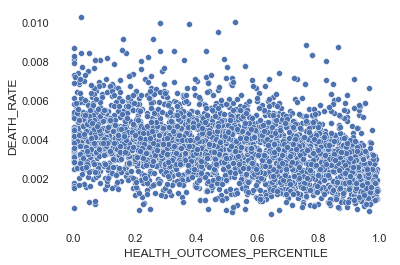

In [18]:
sns.scatterplot(x=final_df.HEALTH_OUTCOMES_PERCENTILE, y=final_df.DEATH_RATE)

In [19]:
final_df['Booster Coverage'].corr(final_df.HEALTH_OUTCOMES_PERCENTILE)

0.2111093652810197

In [20]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 3081 entries, 1001.0 to 56045.0
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   State                       3081 non-null   object 
 1   County                      3081 non-null   object 
 2   # of Ranked Counties        3081 non-null   int64  
 3   HEALTH_OUTCOMES_RANK        3081 non-null   float64
 4   HEALTH_OUTCOMES_QUARTILE    3081 non-null   float64
 5   HEALTH_FACTORS_RANK         3081 non-null   float64
 6   HEALTH_FACTORS_QUARTILE     3081 non-null   float64
 7   HEALTH_OUTCOMES_PERCENTILE  3081 non-null   float64
 8   HEALTH_FACTORS_PERCENTILE   3081 non-null   float64
 9   COUNTY                      2877 non-null   object 
 10  STATE                       2877 non-null   object 
 11  DEATHS                      2877 non-null   float64
 12  Partial Coverage            2877 non-null   float64
 13  Booster Coverage       

In [21]:
big_counties = final_df[final_df.POPULATION > 50000]

small_counties = final_df.drop(big_counties.index)



print(big_counties['Booster Coverage'].corr(big_counties.DEATH_RATE))

print(small_counties['Booster Coverage'].corr(small_counties.DEATH_RATE))

print(big_counties.MEDIAN_HOUSEHOLD.corr(big_counties.DEATH_RATE))

print(small_counties.MEDIAN_HOUSEHOLD.corr(small_counties.DEATH_RATE))

## construct a linear model for DEATH_RATE based on POPULATION

#sns.histplot(final_df.POPULATION - final_df.POPN)

big_counties.corr().DEATH_RATE

-0.46517579994619895
-0.3387994860734444
-0.48960025253470413
-0.42967393221266226


# of Ranked Counties          0.136818
HEALTH_OUTCOMES_RANK          0.439113
HEALTH_OUTCOMES_QUARTILE      0.414159
HEALTH_FACTORS_RANK           0.401087
HEALTH_FACTORS_QUARTILE       0.393585
HEALTH_OUTCOMES_PERCENTILE   -0.438301
HEALTH_FACTORS_PERCENTILE    -0.421498
DEATHS                        0.083609
Partial Coverage             -0.352388
Booster Coverage             -0.465176
Complete Coverage            -0.405855
POPN                         -0.090745
DEATH_RATE                    1.000000
PER_CAPITA_RANK               0.533157
PER_CAPITA                   -0.489629
MEDIAN_HOUSEHOLD             -0.489600
MEDIAN_FAMILY                -0.535390
POPULATION                   -0.079075
HOUSEHOLDS                   -0.084877
Name: DEATH_RATE, dtype: float64

In [22]:
small_counties.corr().DEATH_RATE

# of Ranked Counties          0.289058
HEALTH_OUTCOMES_RANK          0.385194
HEALTH_OUTCOMES_QUARTILE      0.253248
HEALTH_FACTORS_RANK           0.356275
HEALTH_FACTORS_QUARTILE       0.222963
HEALTH_OUTCOMES_PERCENTILE   -0.267815
HEALTH_FACTORS_PERCENTILE    -0.234231
DEATHS                        0.313202
Partial Coverage             -0.233757
Booster Coverage             -0.338799
Complete Coverage            -0.262724
POPN                         -0.151948
DEATH_RATE                    1.000000
PER_CAPITA_RANK               0.391480
PER_CAPITA                   -0.396112
MEDIAN_HOUSEHOLD             -0.429674
MEDIAN_FAMILY                -0.429183
POPULATION                   -0.128230
HOUSEHOLDS                   -0.141844
Name: DEATH_RATE, dtype: float64

In [23]:
gaz = pd.read_csv("2021_Gaz_counties_national.txt", delimiter="\t").rename(columns={'GEOID': 'FIPS'}).set_index("FIPS")

gaz = gaz[["ALAND_SQMI"]]

gaz


,ALAND_SQMI
FIPS,
1001,594.456
1003,1589.836
1005,885.008
1007,622.470
1009,644.891
...,...
72145,45.848
72147,50.788
72149,35.637


In [24]:
final_df = final_df.join(gaz)



In [25]:
final_df['DENSITY'] = final_df.POPULATION / final_df.ALAND_SQMI

In [26]:
final_df.corr().DENSITY

# of Ranked Counties         -0.054413
HEALTH_OUTCOMES_RANK         -0.077572
HEALTH_OUTCOMES_QUARTILE     -0.061956
HEALTH_FACTORS_RANK          -0.072357
HEALTH_FACTORS_QUARTILE      -0.034989
HEALTH_OUTCOMES_PERCENTILE    0.056878
HEALTH_FACTORS_PERCENTILE     0.038822
DEATHS                        0.482588
Partial Coverage              0.227216
Booster Coverage              0.144189
Complete Coverage             0.209964
POPN                          0.394062
DEATH_RATE                   -0.045935
PER_CAPITA_RANK              -0.135687
PER_CAPITA                    0.180433
MEDIAN_HOUSEHOLD              0.147730
MEDIAN_FAMILY                 0.140970
POPULATION                    0.402134
HOUSEHOLDS                    0.416505
ALAND_SQMI                   -0.044352
DENSITY                       1.000000
Name: DENSITY, dtype: float64

In [27]:
# import statsmodels.formula.api as smf
# import statsmodels.api as sm
# from sklearn.model_selection import train_test_split

# X = final_df
# Y = final_df.DEATH_RATE

# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
#         test_size=0.20, random_state = 123) 

# #model = smf.ols(formula='DEATH_RATE ~ MEDIAN_FAMILY + HEALTH_FACTORS_RANK', data=X_train).fit()

# factors = ['HEALTH_OUTCOMES_PERCENTILE', 'HEALTH_FACTORS_PERCENTILE', 'Complete Coverage', 'DENSITY']

# best = ['', 0]
# for f in factors:
#         f_str = f'DEATH_RATE ~ MEDIAN_FAMILY + {f}'
#         this_model = smf.ols(formula=f_str, data=X_train).fit()
#         if this_model.rsquared > best[1]:
#                 best = [f, this_model.rsquared]


# print(best)

# #print(model.summary())



SyntaxError: invalid syntax (<unknown>, line 1)

In [28]:
final_df.corr().DEATH_RATE

# of Ranked Counties          0.272872
HEALTH_OUTCOMES_RANK          0.442792
HEALTH_OUTCOMES_QUARTILE      0.342461
HEALTH_FACTORS_RANK           0.418427
HEALTH_FACTORS_QUARTILE       0.328953
HEALTH_OUTCOMES_PERCENTILE   -0.361928
HEALTH_FACTORS_PERCENTILE    -0.346459
DEATHS                       -0.050999
Partial Coverage             -0.342919
Booster Coverage             -0.421163
Complete Coverage            -0.373315
POPN                         -0.149177
DEATH_RATE                    1.000000
PER_CAPITA_RANK               0.484569
PER_CAPITA                   -0.473466
MEDIAN_HOUSEHOLD             -0.493019
MEDIAN_FAMILY                -0.506958
POPULATION                   -0.142467
HOUSEHOLDS                   -0.150586
ALAND_SQMI                   -0.062324
DENSITY                      -0.045935
Name: DEATH_RATE, dtype: float64

In [29]:
## OK, let's get the actual subfactors for counties



headings = ['Length of Life', 'Quality of Life', 'Health Behaviors', 
            'Clinical Care', 'Social And Economic Factors', 'Physical Environment']

change_dict = {}

col_types  = {'# of Ranked Counties': float}

for (count, h) in enumerate(headings):
    if count == 0:
        rank_name = "Rank"
    else:
        rank_name = f"Rank.{count}"

    h_underscored = "_".join(h.split(" "))

    col_name_on = f'{h_underscored}_Percentile'
    change_dict[rank_name] =  col_name_on
    col_types[col_name_on] = float


subrankings = pd.read_excel(xls, "Outcomes & Factors SubRankings", header=1) \
                .rename(columns=change_dict)


subrankings = subrankings[subrankings['Length_of_Life_Percentile'] != 'NR'] \
                .astype(col_types) \
                .dropna()

## TODO: need to fix numeric types here

cols = list(change_dict.values())

for factor in cols:
    subrankings[factor] = (subrankings['# of Ranked Counties'] - subrankings[factor]) / subrankings['# of Ranked Counties']


cols_to_get = list(change_dict.values())
cols_to_get.append("FIPS")

# only take columns we need
subrankings = subrankings.loc[:, cols_to_get].set_index("FIPS")

subrankings


#joined = deaths_cleaned.set_index('FIPS').join(unvaxed_by_fips.set_index('FIPS'), how='inner')

final_with_subrankings = final_df.join(subrankings, how='inner')

final_with_subrankings

,State,County,# of Ranked Counties,HEALTH_OUTCOMES_RANK,HEALTH_OUTCOMES_QUARTILE,HEALTH_FACTORS_RANK,HEALTH_FACTORS_QUARTILE,HEALTH_OUTCOMES_PERCENTILE,HEALTH_FACTORS_PERCENTILE,COUNTY,...,POPULATION,HOUSEHOLDS,ALAND_SQMI,DENSITY,Length_of_Life_Percentile,Quality_of_Life_Percentile,Health_Behaviors_Percentile,Clinical_Care_Percentile,Social_And_Economic_Factors_Percentile,Physical_Environment_Percentile
FIPS,,,,,,,,,,,,,,,,,,,,,
1001.0,Alabama,Autauga,67,6.0,1.0,9.0,1.0,0.910448,0.865672,Autauga,...,54907.0,20071.0,594.456,92.365120,0.925373,0.910448,0.865672,0.731343,0.925373,0.313433
1003.0,Alabama,Baldwin,67,2.0,1.0,3.0,1.0,0.970149,0.955224,Baldwin,...,187114.0,73283.0,1589.836,117.693901,0.940299,0.970149,0.955224,0.895522,0.970149,0.970149
1005.0,Alabama,Barbour,67,51.0,4.0,59.0,4.0,0.238806,0.119403,Barbour,...,27321.0,9200.0,885.008,30.870907,0.343284,0.194030,0.179104,0.432836,0.074627,0.805970
1007.0,Alabama,Bibb,67,45.0,3.0,42.0,3.0,0.328358,0.373134,Bibb,...,22754.0,7091.0,622.470,36.554372,0.223881,0.611940,0.388060,0.462687,0.313433,0.462687
1009.0,Alabama,Blount,67,23.0,2.0,25.0,2.0,0.656716,0.626866,Blount,...,57623.0,21108.0,644.891,89.353084,0.462687,0.805970,0.746269,0.313433,0.701493,0.194030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56037.0,Wyoming,Sweetwater,23,17.0,3.0,11.0,2.0,0.260870,0.521739,Sweetwater,...,44437.0,16682.0,10426.980,4.261733,0.260870,0.173913,0.652174,0.652174,0.347826,0.217391
56039.0,Wyoming,Teton,23,1.0,1.0,1.0,1.0,0.956522,0.956522,Teton,...,21575.0,7583.0,3996.849,5.398002,0.956522,0.956522,0.956522,0.913043,0.956522,0.347826
56041.0,Wyoming,Uinta,23,21.0,4.0,14.0,3.0,0.086957,0.391304,Uinta,...,21040.0,7290.0,2081.721,10.107022,0.173913,0.043478,0.304348,0.478261,0.391304,0.478261


In [30]:
final_with_subrankings.corr()['DEATH_RATE']

# of Ranked Counties                      0.272872
HEALTH_OUTCOMES_RANK                      0.442792
HEALTH_OUTCOMES_QUARTILE                  0.342461
HEALTH_FACTORS_RANK                       0.418427
HEALTH_FACTORS_QUARTILE                   0.328953
HEALTH_OUTCOMES_PERCENTILE               -0.361928
HEALTH_FACTORS_PERCENTILE                -0.346459
DEATHS                                   -0.050999
Partial Coverage                         -0.342919
Booster Coverage                         -0.421163
Complete Coverage                        -0.373315
POPN                                     -0.149177
DEATH_RATE                                1.000000
PER_CAPITA_RANK                           0.484569
PER_CAPITA                               -0.473466
MEDIAN_HOUSEHOLD                         -0.493019
MEDIAN_FAMILY                            -0.506958
POPULATION                               -0.142467
HOUSEHOLDS                               -0.150586
ALAND_SQMI                     

In [ ]:
# X = final_with_subrankings
# Y = final_with_subrankings.DEATH_RATE

# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
# test_size=0.20, random_state = 123) 


# factors = list(change_dict.values())
# for x in ['MEDIAN_FAMILY', 'HEALTH_OUTCOMES_PERCENTILE', 'HEALTH_FACTORS_PERCENTILE', 'UNVAX_PERCENT', 'DENSITY']:
#     factors.append(x)


# best = ['', 0]
# best_model = None
# for f in factors:
#     f_str = f'DEATH_RATE ~ MEDIAN_FAMILY + UNVAX_PERCENT + Length_of_Life_Percentile + {f}'
#     this_model = smf.ols(formula=f_str, data=X_train).fit()
#     if this_model.rsquared > best[1]:
#         best = [f, this_model.rsquared]
#         best_model = this_model


# print(best_model.summary())

In [ ]:
## I want to look at the differences between low income and high income counties
## as far as aggregate statistics (mean household income, etc.)

final_with_subrankings.columns

In [ ]:
median_of_medians = final_with_subrankings['MEDIAN_HOUSEHOLD'].quantile()

## NOTE: this isn't weighted by county population!
low_income = final_with_subrankings[final_with_subrankings['MEDIAN_HOUSEHOLD'] < median_of_medians]

high_income = final_with_subrankings[final_with_subrankings['MEDIAN_HOUSEHOLD'] >= median_of_medians]

print(low_income.corr()['DEATH_RATE'])

#print(high_income.corr()['DEATH_RATE'])


In [ ]:
low_income.loc[low_income['State'] == 'Texas', 'Partial Coverage']

In [ ]:
ala_deaths = low_income[low_income.State == 'Alabama'].DEATHS

sum(ala_deaths)

In [ ]:
## so I need to group by state and look at total deaths vs. total population

#.pivot_table("CASES", "FIPS", "CASE_TYPE")



li_gbs = low_income.groupby("State").sum() 

low_deathrates = li_gbs['DEATHS'] / li_gbs['POPN']



low_deathrates.describe()

In [ ]:
hi_gbs = high_income.groupby("State").sum()

hi_deathrates = hi_gbs['DEATHS'] / hi_gbs['POPN']

sns.histplot(low_deathrates, stat='proportion')
sns.histplot(hi_deathrates, stat='proportion', color='gold')

hi_deathrates.describe()

### NOTE: these are grouped by state, which is kind of nonsensical!

In [ ]:
INCOME_THRESH = 65000

low_income = final_with_subrankings[final_with_subrankings['MEDIAN_HOUSEHOLD'] < 65000]
li_gbs = low_income.groupby("State").sum() 
low_deathrates = li_gbs['DEATHS'] / li_gbs['POPN']


high_income = final_with_subrankings[final_with_subrankings['MEDIAN_HOUSEHOLD'] >= 65000]
hi_gbs = high_income.groupby("State").sum()
hi_deathrates = hi_gbs['DEATHS'] / hi_gbs['POPN']



sns.histplot(low_deathrates, stat='proportion')
sns.histplot(hi_deathrates, stat='proportion', color='gold')

print(low_deathrates.describe())

print(hi_deathrates.describe())

final_with_subrankings['MEDIAN_HOUSEHOLD'].describe()

In [ ]:
INCOME_SPLITS = [final_with_subrankings['MEDIAN_HOUSEHOLD'].quantile(x) for x in [.25, .5, .75]]

income_stats = {}

for i in INCOME_SPLITS:
    lo = final_with_subrankings[final_with_subrankings['MEDIAN_HOUSEHOLD'] < i]
    hi = final_with_subrankings[final_with_subrankings['MEDIAN_HOUSEHOLD'] >= i]

    income_stats[f"{i}"] = dict(
        lo = lo,
        hi = hi
    )

In [ ]:
income_stats.keys()

In [ ]:
#income_stats['37898.0']['lo'].describe()

# for x in INCOME_SPLITS:
#     print(f">>>>DOING {x}")
#     lo = income_stats[str(x)]['lo']



#     print()
#     print(income_stats[str(x)]['hi']['DEATH_RATE'].describe())


### NO NO NO> this is all bogus, man. The mean death rates, etc. don't matter here. you need to account for population.


In [36]:
## getting partisanship data.

voting_df = pd.read_csv("countypres_2000-2016.csv")


repub = voting_df.loc[(voting_df.year == 2016) & (voting_df.party == "republican"), 
["FIPS", "candidatevotes", "totalvotes"]] \
    .dropna() \
    .set_index("FIPS") \
    .rename(columns={"candidatevotes": "2016_repub_votes", 
                    "totalvotes": "2016_total_votes"})

repub

,2016_repub_votes,2016_total_votes
FIPS,,
1001.0,18172.0,24973
1003.0,72883.0,95215
1005.0,5454.0,10469
1007.0,6738.0,8819
1009.0,22859.0,25588
...,...,...
56037.0,12154.0,17130
56039.0,3921.0,12627
56041.0,6154.0,8470


In [37]:
fws = final_with_subrankings.join(repub)

fws

,State,County,# of Ranked Counties,HEALTH_OUTCOMES_RANK,HEALTH_OUTCOMES_QUARTILE,HEALTH_FACTORS_RANK,HEALTH_FACTORS_QUARTILE,HEALTH_OUTCOMES_PERCENTILE,HEALTH_FACTORS_PERCENTILE,COUNTY,...,ALAND_SQMI,DENSITY,Length_of_Life_Percentile,Quality_of_Life_Percentile,Health_Behaviors_Percentile,Clinical_Care_Percentile,Social_And_Economic_Factors_Percentile,Physical_Environment_Percentile,2016_repub_votes,2016_total_votes
FIPS,,,,,,,,,,,,,,,,,,,,,
1001.0,Alabama,Autauga,67,6.0,1.0,9.0,1.0,0.910448,0.865672,Autauga,...,594.456,92.365120,0.925373,0.910448,0.865672,0.731343,0.925373,0.313433,18172.0,24973.0
1003.0,Alabama,Baldwin,67,2.0,1.0,3.0,1.0,0.970149,0.955224,Baldwin,...,1589.836,117.693901,0.940299,0.970149,0.955224,0.895522,0.970149,0.970149,72883.0,95215.0
1005.0,Alabama,Barbour,67,51.0,4.0,59.0,4.0,0.238806,0.119403,Barbour,...,885.008,30.870907,0.343284,0.194030,0.179104,0.432836,0.074627,0.805970,5454.0,10469.0
1007.0,Alabama,Bibb,67,45.0,3.0,42.0,3.0,0.328358,0.373134,Bibb,...,622.470,36.554372,0.223881,0.611940,0.388060,0.462687,0.313433,0.462687,6738.0,8819.0
1009.0,Alabama,Blount,67,23.0,2.0,25.0,2.0,0.656716,0.626866,Blount,...,644.891,89.353084,0.462687,0.805970,0.746269,0.313433,0.701493,0.194030,22859.0,25588.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56037.0,Wyoming,Sweetwater,23,17.0,3.0,11.0,2.0,0.260870,0.521739,Sweetwater,...,10426.980,4.261733,0.260870,0.173913,0.652174,0.652174,0.347826,0.217391,12154.0,17130.0
56039.0,Wyoming,Teton,23,1.0,1.0,1.0,1.0,0.956522,0.956522,Teton,...,3996.849,5.398002,0.956522,0.956522,0.956522,0.913043,0.956522,0.347826,3921.0,12627.0
56041.0,Wyoming,Uinta,23,21.0,4.0,14.0,3.0,0.086957,0.391304,Uinta,...,2081.721,10.107022,0.173913,0.043478,0.304348,0.478261,0.391304,0.478261,6154.0,8470.0


In [38]:
fws['REPUB_PARTISAN'] = fws['2016_repub_votes'] / fws['2016_total_votes']

In [43]:
fws.corr()['REPUB_PARTISAN']

# of Ranked Counties                      0.243437
HEALTH_OUTCOMES_RANK                      0.171959
HEALTH_OUTCOMES_QUARTILE                  0.027828
HEALTH_FACTORS_RANK                       0.159893
HEALTH_FACTORS_QUARTILE                   0.049534
HEALTH_OUTCOMES_PERCENTILE               -0.020671
HEALTH_FACTORS_PERCENTILE                -0.041251
DEATHS                                   -0.297870
Partial Coverage                         -0.693232
Booster Coverage                         -0.589296
Complete Coverage                        -0.687307
POPN                                     -0.348907
DEATH_RATE                                0.330034
PER_CAPITA_RANK                           0.202899
PER_CAPITA                               -0.250413
MEDIAN_HOUSEHOLD                         -0.216464
MEDIAN_FAMILY                            -0.244730
POPULATION                               -0.348636
HOUSEHOLDS                               -0.362479
ALAND_SQMI                     